Importing libraries and modules for machine learning and image segmentation


In [ ]:
!pip install patchify
!pip install wandb
!pip install -U -q segmentation-models
!pip install -q tensorflow==2.12.0
!pip install -q keras==2.12.0

In [ ]:
!wandb login

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [ ]:
import wandb
from wandb.keras import WandbMetricsLogger, WandbModelCheckpoint, WandbCallback
import os
os.environ["SM_FRAMEWORK"] = "tf.keras"
from tensorflow import keras
import tensorflow as tf
import segmentation_models as sm
import cv2
from PIL import Image
import numpy as np
from patchify import patchify
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from matplotlib import pyplot as plt
import random
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose
from keras.layers import concatenate, BatchNormalization, Dropout, Lambda
from keras import backend as K
from keras.utils.vis_utils import plot_model
import shutil
import keras
from IPython.display import clear_output
%matplotlib inline
from keras.models import load_model

Segmentation Models: using `tf.keras` framework.


Filtering the data

In [ ]:
# setting path to the folder
dataset_path = "/content/drive/MyDrive/solar_final"

# creating subdirectories for images and masks
if not os.path.exists(os.path.join(dataset_path, "images")):
    os.makedirs(os.path.join(dataset_path, "images"))

if not os.path.exists(os.path.join(dataset_path, "masks")):
    os.makedirs(os.path.join(dataset_path, "masks"))

# separating images from masks and renaming them
img_count = 0
mask_count = 0

for file in os.listdir(dataset_path):
    if file.endswith(".bmp") and "label" in file:
        mask_count += 1
        new_filename = f"image_part_{mask_count}.png"
        shutil.move(os.path.join(dataset_path, file), os.path.join(dataset_path, "masks", new_filename))

    elif file.endswith(".bmp"):
        img_count += 1
        new_filename = f"image_part_{img_count}.jpg"
        shutil.move(os.path.join(dataset_path, file), os.path.join(dataset_path, "images", new_filename))



In [ ]:
#creating a list of files
for path, subdirs, files in os.walk (dataset_path ):
    dir_name = path.split(os.path.sep)[-1]

    if dir_name == "images":
     img = os.listdir(path)

In [ ]:
img_size = 256
img = cv2.imread(f'{dataset_path }/images/image_part_2.jpg', 1)

#creating a patched-based version of the img
patched_img = patchify(img, (img_size, img_size, 3), step=img_size)
minmaxscaler = MinMaxScaler()

In [ ]:
img.shape

(256, 256, 3)

In [ ]:
print(type(img))

<class 'numpy.ndarray'>


In [ ]:
#creating lists for masks and images
image_dataset = []
mask_dataset = []

#assigning image formats
for image_type in ['images', 'masks']:
    if image_type == 'images':
        image_extension = 'jpg'
    elif image_type == 'masks':
        image_extension = 'png'

    #looping through all the images
    for img_id in range(1, 301):

        #converting img from bgr to rgb
        img = cv2.imread(f'{dataset_path}/{image_type}/image_part_{img_id}.{image_extension}',1)

        #dividing img by the size and patching it
        if img is not None:
            if image_type == 'masks':
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

            size_x = (img.shape[1]//img_size)*img_size
            size_y = (img.shape[0]//img_size)*img_size

            img = Image.fromarray(img)
            img = img.crop((0,0, size_x, size_y))

            img = np. array(img)
            patched_img = patchify(img, (img_size, img_size, 3), step=img_size)

            #adding masks patches and images to the list
            for i in range (patched_img.shape[0]):
                for j in range (patched_img.shape[1]):

                    if image_type == 'images':
                        indiv_patched_img = patched_img[i, j, :, : ]
                        indiv_patched_img = minmaxscaler.fit_transform(indiv_patched_img.reshape(-1, indiv_patched_img.shape[-1])).reshape(indiv_patched_img.shape)
                        indiv_patched_img = indiv_patched_img[0]
                        image_dataset.append(indiv_patched_img)

                    elif image_type == 'masks':
                        indiv_patched_mask = patched_img[i, j, :, :]
                        indiv_patched_mask = indiv_patched_mask[0]
                        mask_dataset.append(indiv_patched_mask)


In [ ]:
#converting image and mask data sets to array
image_dataset = np.array(image_dataset)
mask_dataset = np.array(mask_dataset)
len(image_dataset)
len(mask_dataset)
print(len(image_dataset))
print(len(mask_dataset))

300
300


In [ ]:
#creating class for solar pannels
class_solar_pannels = '#d4d4d4'
class_solar_pannels = class_solar_pannels.lstrip('#')
class_solar_pannels = np.array(tuple(int(class_solar_pannels[i:i+2], 16) for i in (0,2,4)))

#creating class for unlabeled objects
class_unlabeled = '#000000'
class_unlabeled = class_unlabeled.lstrip('#')
class_unlabeled = np.array(tuple(int(class_unlabeled[i:i+2], 16) for i in (0,2,4)))


In [ ]:
label = indiv_patched_mask

#creating a func to convert labeled img into segmentation map
def rgb_to_label(label):
  label_segment = np.zeros(label.shape, dtype=np.uint8)
  label_segment[np.all(label == class_solar_pannels, axis=-1)] = 0
  label_segment[np.all(label == class_unlabeled, axis=-1)] = 1
  label_segment = label_segment[:,:,0]
  return label_segment

In [ ]:
#creating labels list to store segmentation maps generated from masks dataset
labels = []
#looping through masks and generating segmentation map for images
for i in range(mask_dataset.shape[0]):
  label = rgb_to_label(mask_dataset[i])
  labels.append(label)

labels = np.array(labels)
labels = np.expand_dims(labels, axis=3)

In [ ]:
np.unique(labels)
print("Total unique labels based on masks: ",format(np.unique(labels)))

Total unique labels based on masks:  [0 1]


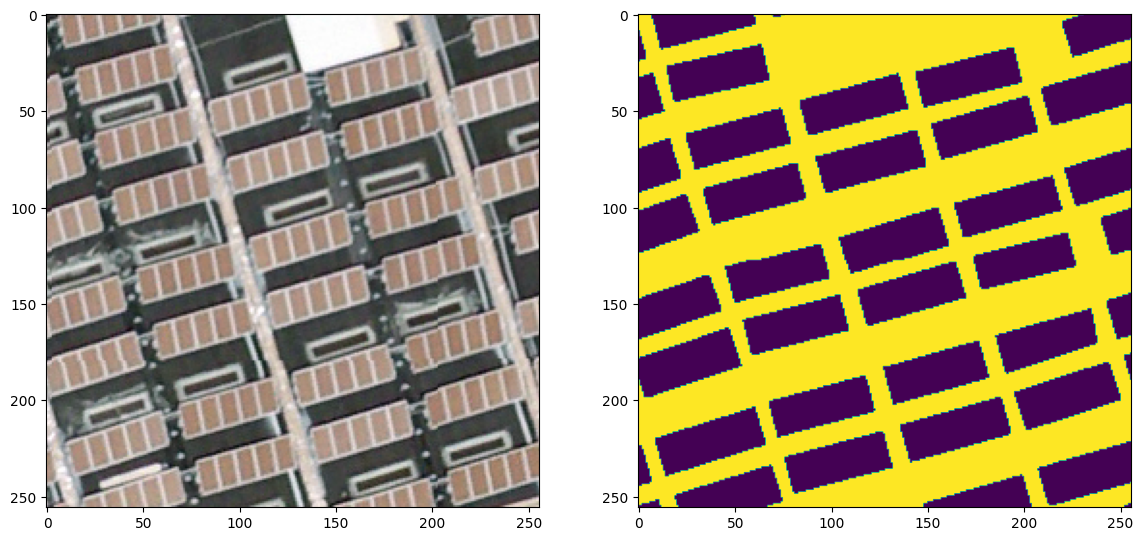

In [ ]:
#selecting random img and corresponding segmentation map
random_image_id = random.randint(0, len(image_dataset))
plt.figure(figsize=(14,8))
plt.subplot(121)
plt.imshow(image_dataset[random_image_id])
plt.subplot(122)
plt.imshow(labels[random_image_id][:,:,0])

In [ ]:
total_classes = len(np.unique(labels))
total_classes

2

In [ ]:
#creating a binary matrix for each label
labels_categorical_dataset = to_categorical(labels, num_classes=total_classes)

#specifing the training data(85%) and testing data(15%) to evaluate model performance
master_trianing_dataset = image_dataset
X_train, X_test, y_train, y_test = train_test_split(master_trianing_dataset, labels_categorical_dataset, test_size=0.15, random_state=100)

image_height = X_train.shape[1]
image_width = X_train.shape[2]
image_channels = X_train.shape[3]
total_classes = y_train.shape[3]

# print(image_height)
# print(image_width)
print(image_channels)
# print(total_classes)

3


In [ ]:
# print(X_train.shape)
# print(X_test.shape)
# print(y_train.shape)
# print(y_test.shape)

In [ ]:
labels_categorical_dataset.shape

(300, 256, 256, 2)

Creating and testing the model

In [ ]:
#computing the IoU between true and predicted labels
def jaccard_coef(y_true, y_pred):
  y_true_flatten = K.flatten(y_true)
  y_pred_flatten = K.flatten(y_pred)
  intersection = K.sum(y_true_flatten * y_pred_flatten)
  final_coef_value = (intersection + 1.0) / (K.sum(y_true_flatten) + K.sum(y_pred_flatten) - intersection + 1.0)
  return final_coef_value


In [ ]:
#segmenting images into separate classes
def multi_unet_model(n_classes=2, image_height=256, image_width=256, image_channels=1):

  inputs = Input((image_height, image_width, image_channels))

  source_input = inputs

  c1 = Conv2D(16, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(source_input)
  c1 = Dropout(0.2)(c1)
  c1 = Conv2D(16, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c1)
  p1 = MaxPooling2D((2,2))(c1)

  c2 = Conv2D(32, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(p1)
  c2 = Dropout(0.2)(c2)
  c2 = Conv2D(32, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c2)
  p2 = MaxPooling2D((2,2))(c2)

  c3 = Conv2D(64, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(p2)
  c3 = Dropout(0.2)(c3)
  c3 = Conv2D(64, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c3)
  p3 = MaxPooling2D((2,2))(c3)

  c4 = Conv2D(128, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(p3)
  c4 = Dropout(0.2)(c4)
  c4 = Conv2D(128, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c4)
  p4 = MaxPooling2D((2,2))(c4)

  c5 = Conv2D(256, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(p4)
  c5 = Dropout(0.2)(c5)
  c5 = Conv2D(256, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c5)

  u6 = Conv2DTranspose(128, (2,2), strides=(2,2), padding="same")(c5)
  u6 = concatenate([u6, c4])
  c6 = Conv2D(128, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(u6)
  c6 = Dropout(0.2)(c6)
  c6 = Conv2D(128, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c6)

  u7 = Conv2DTranspose(64, (2,2), strides=(2,2), padding="same")(c6)
  u7 = concatenate([u7, c3])
  c7 = Conv2D(64, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(u7)
  c7 = Dropout(0.2)(c7)
  c7 = Conv2D(64, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c7)

  u8 = Conv2DTranspose(32, (2,2), strides=(2,2), padding="same")(c7)
  u8 = concatenate([u8, c2])
  c8 = Conv2D(32, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(u8)
  c8 = Dropout(0.2)(c8)
  c8 = Conv2D(32, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c8)

  u9 = Conv2DTranspose(16, (2,2), strides=(2,2), padding="same")(c8)
  u9 = concatenate([u9, c1], axis=3)
  c9 = Conv2D(16, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(u9)
  c9 = Dropout(0.2)(c9)
  c9 = Conv2D(16, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c9)

  outputs = Conv2D(n_classes, (1,1), activation="softmax")(c9)

  model = Model(inputs=[inputs], outputs=[outputs])
  return model

In [ ]:
metrics = ["accuracy", jaccard_coef]

In [ ]:
#returning deep learning model
def get_deep_learning_model():
  return multi_unet_model(n_classes=total_classes,
                          image_height=image_height,
                          image_width=image_width,
                          image_channels=image_channels)

In [ ]:
model = get_deep_learning_model()
#weights for the loss func
weights = [0.1666, 0.1666]

#creating dice loss func
dice_loss = sm.losses.DiceLoss(class_weights = weights)

#creating focal loss func
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

In [ ]:
tf.keras.backend.clear_session()

In [ ]:
model.compile(optimizer="adam", loss=total_loss, metrics=metrics)

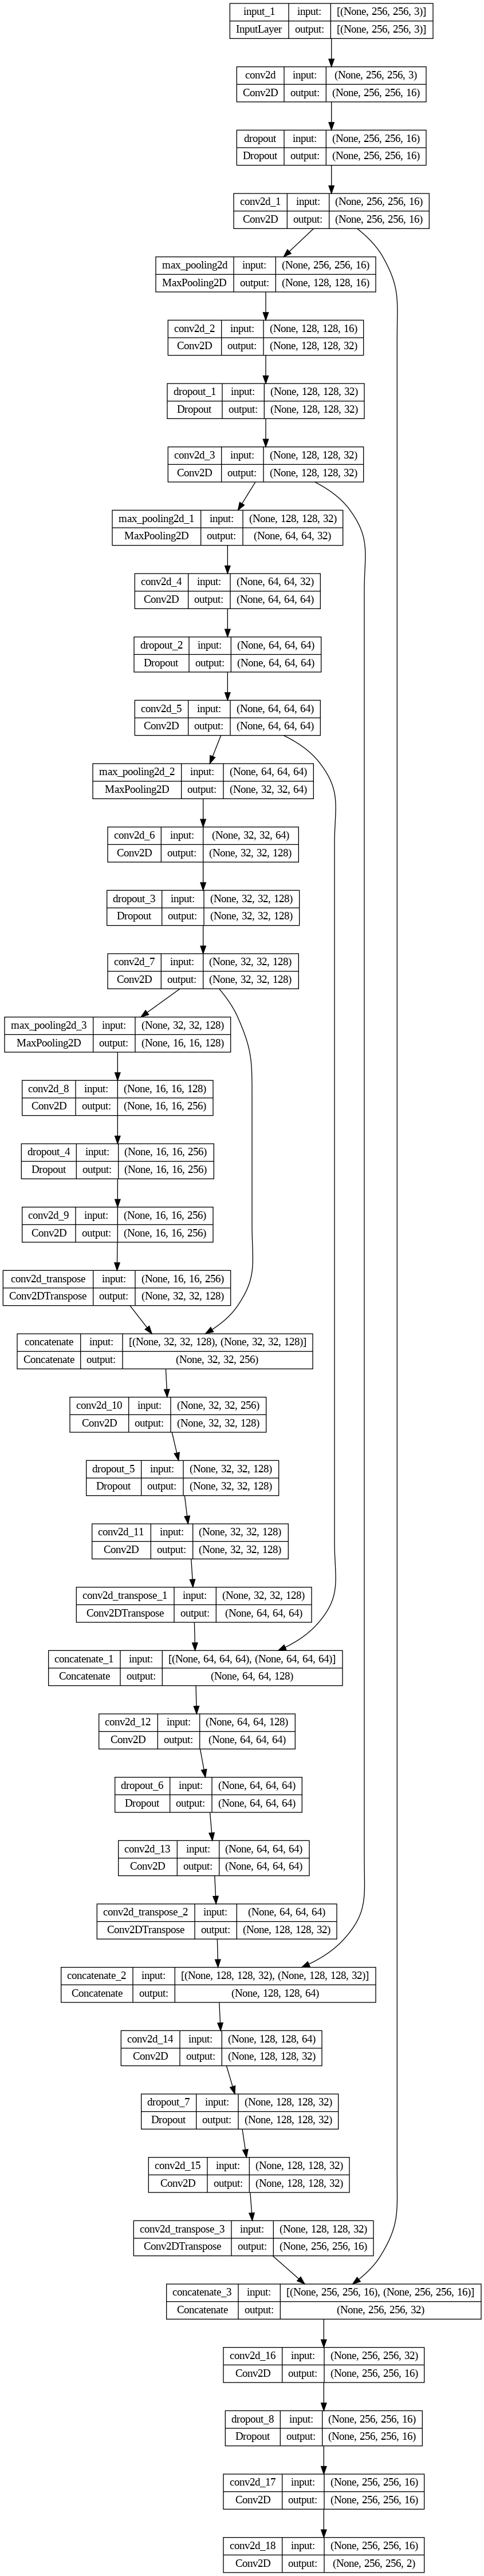

In [ ]:
plot_model(model, to_file = "model.png", show_shapes = True, show_layer_names = True)

In [ ]:
wandb.init()

wandb: Currently logged in as: darinkatovstogan (coursework_tovstohan). Use `wandb login --relogin` to force relogin


In [ ]:
model_history = model.fit(X_train, y_train,
                          batch_size=16,
                          verbose=1,
                          epochs=100,
                          validation_data=(X_test, y_test),
                          callbacks=[WandbCallback()],
                          shuffle=False)

wandb: WARNING The save_model argument by default saves the model in the HDF5 format that cannot save custom objects like subclassed models and custom layers. This behavior will be deprecated in a future release in favor of the SavedModel format. Meanwhile, the HDF5 model is saved as W&B files and the SavedModel as W&B Artifacts.


Epoch 1/100
16/16 [==============================] - ETA: 0s - loss: 0.9401 - accuracy: 0.6714 - jaccard_coef: 0.3593

wandb: Adding directory to artifact (/content/wandb/run-20230627_060753-dguu21ss/files/model-best)... Done. 0.1s


16/16 [==============================] - 32s 681ms/step - loss: 0.9401 - accuracy: 0.6714 - jaccard_coef: 0.3593 - val_loss: 0.9390 - val_accuracy: 0.7641 - val_jaccard_coef: 0.3671
Epoch 2/100
15/16 [===========================>..] - ETA: 0s - loss: 0.9389 - accuracy: 0.7022 - jaccard_coef: 0.3588

wandb: Adding directory to artifact (/content/wandb/run-20230627_060753-dguu21ss/files/model-best)... Done. 0.1s


16/16 [==============================] - 6s 400ms/step - loss: 0.9388 - accuracy: 0.6985 - jaccard_coef: 0.3586 - val_loss: 0.9388 - val_accuracy: 0.7641 - val_jaccard_coef: 0.3675
Epoch 3/100
15/16 [===========================>..] - ETA: 0s - loss: 0.9384 - accuracy: 0.7023 - jaccard_coef: 0.3643

wandb: Adding directory to artifact (/content/wandb/run-20230627_060753-dguu21ss/files/model-best)... Done. 0.1s


16/16 [==============================] - 6s 402ms/step - loss: 0.9384 - accuracy: 0.6986 - jaccard_coef: 0.3639 - val_loss: 0.9380 - val_accuracy: 0.7641 - val_jaccard_coef: 0.3720
Epoch 4/100
15/16 [===========================>..] - ETA: 0s - loss: 0.9380 - accuracy: 0.7023 - jaccard_coef: 0.3660

wandb: Adding directory to artifact (/content/wandb/run-20230627_060753-dguu21ss/files/model-best)... Done. 0.1s


16/16 [==============================] - 6s 411ms/step - loss: 0.9381 - accuracy: 0.6986 - jaccard_coef: 0.3654 - val_loss: 0.9379 - val_accuracy: 0.7641 - val_jaccard_coef: 0.3711
Epoch 5/100
16/16 [==============================] - 1s 39ms/step - loss: 0.9376 - accuracy: 0.6984 - jaccard_coef: 0.3683 - val_loss: 0.9394 - val_accuracy: 0.7641 - val_jaccard_coef: 0.3609
Epoch 6/100
16/16 [==============================] - 1s 38ms/step - loss: 0.9373 - accuracy: 0.6984 - jaccard_coef: 0.3720 - val_loss: 0.9389 - val_accuracy: 0.7641 - val_jaccard_coef: 0.3648
Epoch 7/100
15/16 [===========================>..] - ETA: 0s - loss: 0.9370 - accuracy: 0.7020 - jaccard_coef: 0.3730

wandb: Adding directory to artifact (/content/wandb/run-20230627_060753-dguu21ss/files/model-best)... Done. 0.1s


16/16 [==============================] - 6s 381ms/step - loss: 0.9372 - accuracy: 0.6983 - jaccard_coef: 0.3722 - val_loss: 0.9370 - val_accuracy: 0.7641 - val_jaccard_coef: 0.3801
Epoch 8/100
15/16 [===========================>..] - ETA: 0s - loss: 0.9366 - accuracy: 0.7021 - jaccard_coef: 0.3744

wandb: Adding directory to artifact (/content/wandb/run-20230627_060753-dguu21ss/files/model-best)... Done. 0.1s


16/16 [==============================] - 8s 499ms/step - loss: 0.9369 - accuracy: 0.6984 - jaccard_coef: 0.3735 - val_loss: 0.9365 - val_accuracy: 0.7641 - val_jaccard_coef: 0.3872
Epoch 9/100
15/16 [===========================>..] - ETA: 0s - loss: 0.9364 - accuracy: 0.7023 - jaccard_coef: 0.3768

wandb: Adding directory to artifact (/content/wandb/run-20230627_060753-dguu21ss/files/model-best)... Done. 0.1s


16/16 [==============================] - 6s 405ms/step - loss: 0.9366 - accuracy: 0.6985 - jaccard_coef: 0.3757 - val_loss: 0.9364 - val_accuracy: 0.7641 - val_jaccard_coef: 0.3868
Epoch 10/100
16/16 [==============================] - 1s 39ms/step - loss: 0.9364 - accuracy: 0.6986 - jaccard_coef: 0.3768 - val_loss: 0.9368 - val_accuracy: 0.7641 - val_jaccard_coef: 0.3832
Epoch 11/100
16/16 [==============================] - 1s 37ms/step - loss: 0.9363 - accuracy: 0.6986 - jaccard_coef: 0.3777 - val_loss: 0.9369 - val_accuracy: 0.7641 - val_jaccard_coef: 0.3815
Epoch 12/100
16/16 [==============================] - 1s 38ms/step - loss: 0.9363 - accuracy: 0.6986 - jaccard_coef: 0.3774 - val_loss: 0.9366 - val_accuracy: 0.7641 - val_jaccard_coef: 0.3838
Epoch 13/100
16/16 [==============================] - 1s 38ms/step - loss: 0.9362 - accuracy: 0.6986 - jaccard_coef: 0.3794 - val_loss: 0.9366 - val_accuracy: 0.7641 - val_jaccard_coef: 0.3852
Epoch 14/100
15/16 [===========================

wandb: Adding directory to artifact (/content/wandb/run-20230627_060753-dguu21ss/files/model-best)... Done. 0.1s


16/16 [==============================] - 6s 376ms/step - loss: 0.9361 - accuracy: 0.6986 - jaccard_coef: 0.3793 - val_loss: 0.9362 - val_accuracy: 0.7641 - val_jaccard_coef: 0.3911
Epoch 15/100
15/16 [===========================>..] - ETA: 0s - loss: 0.9357 - accuracy: 0.7023 - jaccard_coef: 0.3816

wandb: Adding directory to artifact (/content/wandb/run-20230627_060753-dguu21ss/files/model-best)... Done. 0.1s


16/16 [==============================] - 6s 402ms/step - loss: 0.9359 - accuracy: 0.6986 - jaccard_coef: 0.3802 - val_loss: 0.9359 - val_accuracy: 0.7641 - val_jaccard_coef: 0.3943
Epoch 16/100
15/16 [===========================>..] - ETA: 0s - loss: 0.9357 - accuracy: 0.7023 - jaccard_coef: 0.3824

wandb: Adding directory to artifact (/content/wandb/run-20230627_060753-dguu21ss/files/model-best)... Done. 0.1s


16/16 [==============================] - 6s 406ms/step - loss: 0.9359 - accuracy: 0.6986 - jaccard_coef: 0.3810 - val_loss: 0.9356 - val_accuracy: 0.7641 - val_jaccard_coef: 0.3951
Epoch 17/100
15/16 [===========================>..] - ETA: 0s - loss: 0.9356 - accuracy: 0.7023 - jaccard_coef: 0.3825

wandb: Adding directory to artifact (/content/wandb/run-20230627_060753-dguu21ss/files/model-best)... Done. 0.1s


16/16 [==============================] - 6s 378ms/step - loss: 0.9358 - accuracy: 0.6986 - jaccard_coef: 0.3811 - val_loss: 0.9352 - val_accuracy: 0.7641 - val_jaccard_coef: 0.3999
Epoch 18/100
16/16 [==============================] - 1s 39ms/step - loss: 0.9357 - accuracy: 0.6986 - jaccard_coef: 0.3821 - val_loss: 0.9360 - val_accuracy: 0.7641 - val_jaccard_coef: 0.3894
Epoch 19/100
15/16 [===========================>..] - ETA: 0s - loss: 0.9355 - accuracy: 0.7023 - jaccard_coef: 0.3840

wandb: Adding directory to artifact (/content/wandb/run-20230627_060753-dguu21ss/files/model-best)... Done. 0.1s


16/16 [==============================] - 6s 401ms/step - loss: 0.9357 - accuracy: 0.6986 - jaccard_coef: 0.3828 - val_loss: 0.9351 - val_accuracy: 0.7641 - val_jaccard_coef: 0.3986
Epoch 20/100
16/16 [==============================] - 1s 40ms/step - loss: 0.9356 - accuracy: 0.6986 - jaccard_coef: 0.3825 - val_loss: 0.9352 - val_accuracy: 0.7641 - val_jaccard_coef: 0.3989
Epoch 21/100
15/16 [===========================>..] - ETA: 0s - loss: 0.9352 - accuracy: 0.7023 - jaccard_coef: 0.3846

wandb: Adding directory to artifact (/content/wandb/run-20230627_060753-dguu21ss/files/model-best)... Done. 0.1s


16/16 [==============================] - 6s 400ms/step - loss: 0.9355 - accuracy: 0.6986 - jaccard_coef: 0.3833 - val_loss: 0.9350 - val_accuracy: 0.7641 - val_jaccard_coef: 0.4031
Epoch 22/100
16/16 [==============================] - 1s 40ms/step - loss: 0.9352 - accuracy: 0.6986 - jaccard_coef: 0.3853 - val_loss: 0.9350 - val_accuracy: 0.7641 - val_jaccard_coef: 0.4064
Epoch 23/100
16/16 [==============================] - 1s 38ms/step - loss: 0.9351 - accuracy: 0.6986 - jaccard_coef: 0.3865 - val_loss: 0.9351 - val_accuracy: 0.7641 - val_jaccard_coef: 0.4002
Epoch 24/100
15/16 [===========================>..] - ETA: 0s - loss: 0.9350 - accuracy: 0.7023 - jaccard_coef: 0.3869

wandb: Adding directory to artifact (/content/wandb/run-20230627_060753-dguu21ss/files/model-best)... Done. 0.1s


16/16 [==============================] - 6s 406ms/step - loss: 0.9352 - accuracy: 0.6986 - jaccard_coef: 0.3857 - val_loss: 0.9345 - val_accuracy: 0.7641 - val_jaccard_coef: 0.4083
Epoch 25/100
16/16 [==============================] - 1s 39ms/step - loss: 0.9352 - accuracy: 0.6986 - jaccard_coef: 0.3853 - val_loss: 0.9347 - val_accuracy: 0.7641 - val_jaccard_coef: 0.4096
Epoch 26/100
16/16 [==============================] - 1s 38ms/step - loss: 0.9351 - accuracy: 0.6986 - jaccard_coef: 0.3862 - val_loss: 0.9345 - val_accuracy: 0.7641 - val_jaccard_coef: 0.4061
Epoch 27/100
16/16 [==============================] - 1s 38ms/step - loss: 0.9349 - accuracy: 0.6986 - jaccard_coef: 0.3877 - val_loss: 0.9349 - val_accuracy: 0.7641 - val_jaccard_coef: 0.4046
Epoch 28/100
16/16 [==============================] - 1s 38ms/step - loss: 0.9348 - accuracy: 0.6984 - jaccard_coef: 0.3871 - val_loss: 0.9350 - val_accuracy: 0.7641 - val_jaccard_coef: 0.3981
Epoch 29/100
16/16 [===========================

wandb: Adding directory to artifact (/content/wandb/run-20230627_060753-dguu21ss/files/model-best)... Done. 0.1s


16/16 [==============================] - 6s 379ms/step - loss: 0.9331 - accuracy: 0.6924 - jaccard_coef: 0.3980 - val_loss: 0.9343 - val_accuracy: 0.7223 - val_jaccard_coef: 0.4059
Epoch 43/100
16/16 [==============================] - 1s 39ms/step - loss: 0.9325 - accuracy: 0.6981 - jaccard_coef: 0.4011 - val_loss: 0.9346 - val_accuracy: 0.7254 - val_jaccard_coef: 0.4086
Epoch 44/100
16/16 [==============================] - 1s 38ms/step - loss: 0.9324 - accuracy: 0.6965 - jaccard_coef: 0.4042 - val_loss: 0.9364 - val_accuracy: 0.7026 - val_jaccard_coef: 0.4044
Epoch 45/100
16/16 [==============================] - 1s 38ms/step - loss: 0.9331 - accuracy: 0.6936 - jaccard_coef: 0.3976 - val_loss: 0.9353 - val_accuracy: 0.7223 - val_jaccard_coef: 0.4105
Epoch 46/100
16/16 [==============================] - 1s 38ms/step - loss: 0.9323 - accuracy: 0.6984 - jaccard_coef: 0.4014 - val_loss: 0.9356 - val_accuracy: 0.7276 - val_jaccard_coef: 0.4139
Epoch 47/100
16/16 [===========================

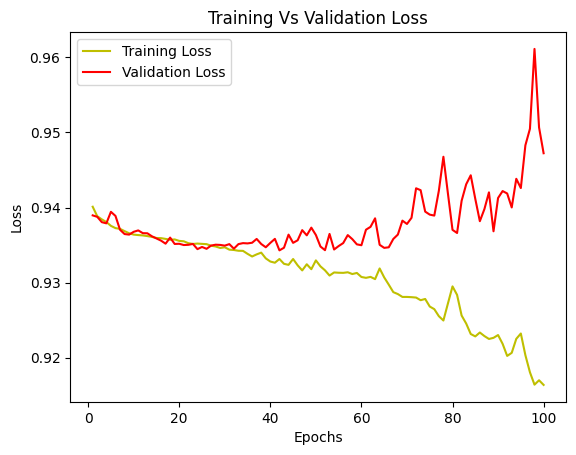

In [ ]:
history_a = model_history
loss = history_a.history['loss']
val_loss = history_a.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label="Training Loss")
plt.plot(epochs, val_loss, 'r', label="Validation Loss")
plt.title("Training Vs Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

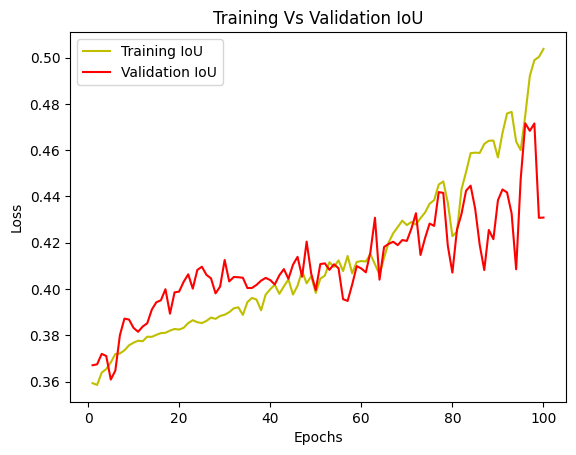

In [ ]:
jaccard_coef = history_a.history['jaccard_coef']
val_jaccard_coef = history_a.history['val_jaccard_coef']

epochs = range(1, len(jaccard_coef) + 1)
plt.plot(epochs, jaccard_coef, 'y', label="Training IoU")
plt.plot(epochs, val_jaccard_coef, 'r', label="Validation IoU")
plt.title("Training Vs Validation IoU")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
model_history.params

{'verbose': 1, 'epochs': 100, 'steps': 16}

In [ ]:
y_pred = model.predict(X_test)
y_pred_argmax = np.argmax(y_pred, axis=3)
y_test_argmax = np.argmax(y_test, axis=3)

2/2 [==============================] - 1s 9ms/step


Saving the model

In [ ]:
model.save("coursework_model.h5")

In [ ]:
!ls -lah

total 23M
drwxr-xr-x 1 root root 4.0K Jun 27 06:11 .
drwxr-xr-x 1 root root 4.0K Jun 27 05:53 ..
drwxr-xr-x 4 root root 4.0K Jun 23 13:40 .config
-rw-r--r-- 1 root root  23M Jun 27 06:11 coursework_model.h5
drwx------ 5 root root 4.0K Jun 27 05:55 drive
-rw-r--r-- 1 root root 351K Jun 27 06:07 model.png
drwxr-xr-x 1 root root 4.0K Jun 23 13:41 sample_data
drwxr-xr-x 3 root root 4.0K Jun 27 06:07 wandb


In [ ]:
model.loss.name

'dice_loss_plus_1focal_loss'

In [ ]:
saved_model = load_model('/content/coursework_model.h5', custom_objects=({'dice_loss_plus_1focal_loss': total_loss, 'jaccard_coef': jaccard_coef}))

In [ ]:
test_image_number = random.randint(0, len(X_test))

test_image = X_test[test_image_number]
ground_truth_image = y_test_argmax[test_image_number]

test_image_input = np.expand_dims(test_image, 0)

prediction = saved_model.predict(test_image_input)
predicted_image = np.argmax(prediction, axis=3)
predicted_image = predicted_image[0,:,:]

1/1 [==============================] - 0s 26ms/step


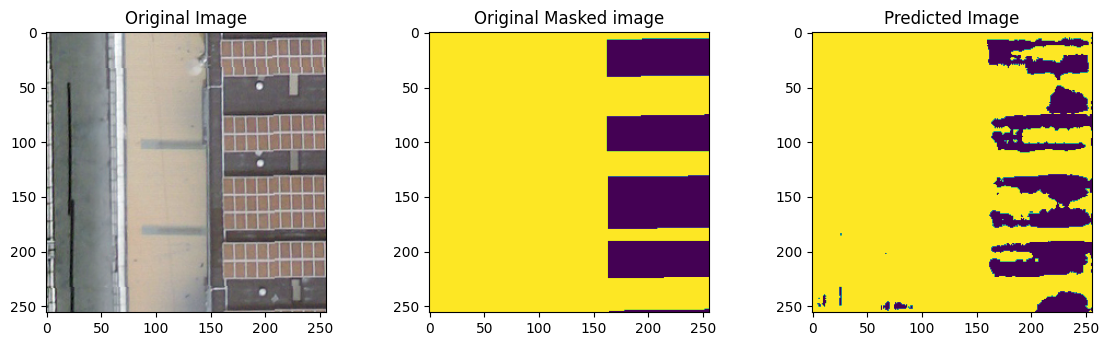

In [ ]:
plt.figure(figsize=(14,8))
plt.subplot(231)
plt.title("Original Image")
plt.imshow(test_image)
plt.subplot(232)
plt.title("Original Masked image")
plt.imshow(ground_truth_image)
plt.subplot(233)
plt.title("Predicted Image")
plt.imshow(predicted_image)

Exporting the model

In [ ]:
!wandb

Usage: wandb [OPTIONS] COMMAND [ARGS]...

Options:
  --version  Show the version and exit.
  --help     Show this message and exit.

Commands:
  agent         Run the W&B agent
  artifact      Commands for interacting with...
  controller    Run the W&B local sweep...
  disabled      Disable W&B.
  docker        Run your code in a docker...
  docker-run    Wrap `docker run` and adds...
  enabled       Enable W&B.
  import        Commands for importing data...
  init          Configure a directory with...
  launch        Launch or queue a W&B Job.
  launch-agent  Run a W&B launch agent.
  launch-sweep  Run a W&B launch sweep...
  login         Login to Weights & Biases
  offline       Disable W&B sync
  online        Enable W&B sync
  pull          Pull files from Weights & Biases
  restore       Restore code, config and...
  scheduler     Run a W&B launch sweep...
  server        Commands for operating a...
  status        Show configuration settings
  sweep         Create a sweep
  sy

In [ ]:
wandb.init(project="solar panles", entity = "darinkatovstogan" )

accuracy,▁▃▃▃▃▃▃▃▃▃▃▃▃▃▂▃▃▃▃▄▃▃▄▃▄▄▅▅▅▅▆▅▆▆▆▆▇▆██
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
jaccard_coef,▁▁▂▂▂▂▂▂▂▂▂▂▂▂▃▃▃▃▃▃▃▃▃▄▄▃▄▄▄▅▅▅▅▆▆▆▇▆▇█
loss,██▇▇▇▇▇▇▇▇▇▆▆▆▆▆▆▆▆▆▆▅▅▅▅▆▅▄▄▄▄▄▄▃▃▃▂▃▁▁
val_accuracy,████████████▇▅▆▆▄▄▆▃▅▅▄▅▅▄▅▅▄▄▅▃▅▅▃▅▄▁▄▂
val_jaccard_coef,▁▁▁▃▂▂▃▃▄▃▄▃▄▄▃▄▄▄▄▄▄▄▃▄▄▄▅▅▆▅▆▅▆▆▄▅▆▄█▅
val_loss,▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▂▂▂▂▁▁▁▁▂▁▂▃▅▃▄▄▄▅▃▂▄▅█▇
accuracy,0.76311
best_epoch,41
best_val_loss,0.93429
epoch,99


In [ ]:
wandb.log({'accuracy': jaccard_coef, 'loss': total_loss})

In [ ]:
wandb.config.dropout = 0.1

Predicting using unseen data

In [ ]:
#--- code to convert bmp image to jpg format ---#
# #converting the unseen img to jpg
# from PIL import Image

# def convert_bmp_to_jpg(bmp_file, jpg_file):
#     try:
#         # open the BMP image
#         bmp_image = Image.open(bmp_file)

#         #convert to RGB mode (in case it's a different mode)
#         bmp_image = bmp_image.convert("RGB")

#         #save as JPG
#         bmp_image.save(jpg_file, "JPEG")

#         print(f"Conversion successful. Image saved as {jpg_file}")
#     except Exception as e:
#         print(f"Error converting image: {e}")

# #specify the input BMP image and output JPG image filenames
# bmp_file = "/content/PV01_325119_1204074.bmp"
# jpg_file = "output_image_test.jpg"

# #call the function to convert and save the image
# convert_bmp_to_jpg(bmp_file, jpg_file)


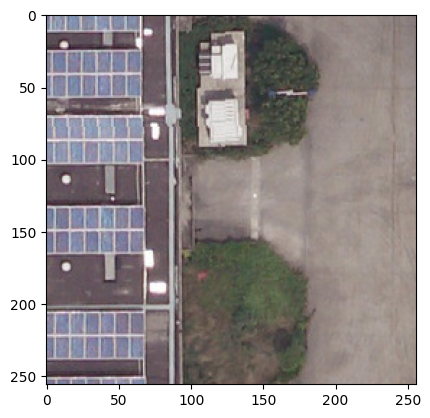

In [ ]:
plt.imshow(Image.open("/content/drive/MyDrive/solar_final/images to test/test_image.jpg"))

In [ ]:
image_test = Image.open("/content/drive/MyDrive/solar_final/images to test/test_image.jpg")
image_test = image_test.resize((256, 256))
image_test = np.array(image_test)
image_test = np.expand_dims(image_test, 0)

In [ ]:
prediction = saved_model.predict(image_test)

1/1 [==============================] - 0s 317ms/step


In [ ]:
predicted_image = np.argmax(prediction, axis=3)
predicted_image = predicted_image[0,:,:]

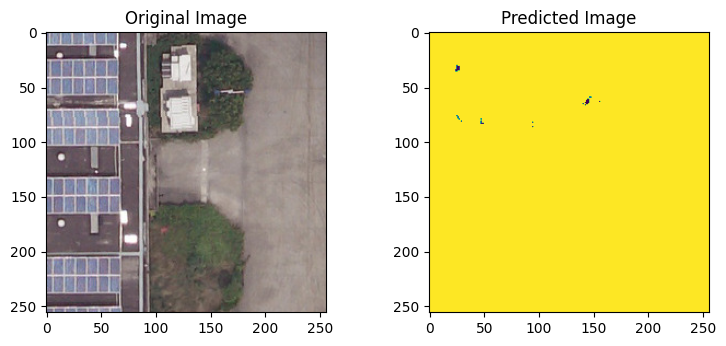

In [ ]:
plt.figure(figsize=(14,8))
plt.subplot(231)
plt.title("Original Image")
plt.imshow(Image.open("/content/drive/MyDrive/solar_final/images to test/test_image.jpg"))
plt.subplot(232)
plt.title("Predicted Image")
plt.imshow(predicted_image)